<a href="https://colab.research.google.com/github/expectnothin/asrkr-ml-py/blob/main/shivzTollywoodMovies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving final_telugu_movies_2024.xls to final_telugu_movies_2024.xls


In [2]:
import pandas as pd

df = pd.read_excel("final_telugu_movies_2024.xls")  # replace with actual filename shown after upload
df.head()


,rank,movie,worldwide,india_net,india_gross,overseas,budget,verdict,production_company,director,cast
0,2025-12-27,Drinker Sai,0.64,0.58,0.64,-,1.0,NaN,Everest Cinemas Smart Screens Entertainments,Kiran Tirumalasetti,DharmaAishwarya SharmaPosani Krishna MuraliSri...
1,2025-12-27,Blood,0.00,0.00,0.00,-,1.0,NaN,NaN,NaN,NaN
2,2025-12-27,Legally Veer,0.05,0.04,0.05,-,1.0,NaN,Silver Cast,Ravi Gogula,Veer ReddyDayanand ReddyDelhi GaneshanGiridhar
3,2025-12-27,O Thandri Theerpu,0.00,0.00,0.00,-,1.0,NaN,NaN,NaN,NaN
4,2025-12-27,Vaaradhi,0.06,0.05,0.06,-,1.0,NaN,NaN,NaN,NaN


In [ ]:
df.shape                # (rows, columns)
df.columns.tolist()     # Column names
df.head()               # First few rows
df.tail()               # Last few rows
df.info()               # Nulls, datatypes

In [3]:
df['verdict'].value_counts()

,count
verdict,
Blockbuster,13
Hit,10
Disaster,8
Average,8


In [22]:
df['rank'] = df['rank'].dt.strftime('%Y%m%d').astype(float)  # if truly date-based rank


In [ ]:
def clean_money(col):
    return col.str.replace('₹', '', regex=False)\
              .str.replace(',', '', regex=False)\
              .str.extract(r'([\d.]+)')\
              .astype(float)

df['overseas_clean'] = clean_money(df['overseas'])


In [24]:
# Heuristic label: Hit if worldwide >= 2× budget
df['verdict_heuristic'] = df.apply(lambda row: 'Hit' if row['worldwide'] >= 2 * row['budget'] else 'Flop', axis=1)


In [25]:
df_clean = df.dropna(subset=['movie', 'budget', 'worldwide', 'overseas_clean'])


📊 Classification Report:
              precision    recall  f1-score   support

     Average       0.00      0.00      0.00         0
 Blockbuster       1.00      1.00      1.00         1
        Flop       1.00      1.00      1.00         1
         Hit       1.00      0.80      0.89         5

    accuracy                           0.86         7
   macro avg       0.75      0.70      0.72         7
weighted avg       1.00      0.86      0.92         7



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: U

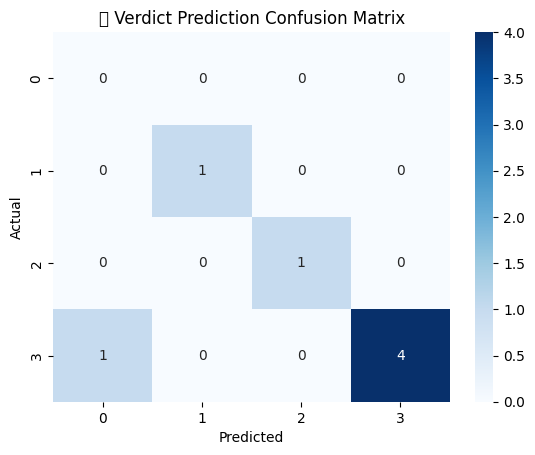

In [4]:
# Step 1: Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 2: Load and prepare the data
df = pd.read_excel("final_telugu_movies_2024.xls")  # change to actual file name
df['overseas_clean'] = df['overseas'].astype(str).str.replace('₹','').str.replace(',','').str.extract(r'([\d.]+)').astype(float)

# Optional: Build a heuristic verdict if real verdict is sparse
df['verdict_heuristic'] = df.apply(lambda row: 'Hit' if row['worldwide'] >= 2 * row['budget'] else 'Flop', axis=1)
df['verdict_final'] = df['verdict'].combine_first(df['verdict_heuristic'])  # Use real verdict when available

# Drop rows with missing critical features
df_model = df[['budget', 'overseas_clean', 'worldwide', 'production_company', 'director', 'cast', 'verdict_final']].dropna()

# Step 3: Encode categorical variables
label_encoders = {}
for col in ['production_company', 'director', 'cast']:
    le = LabelEncoder()
    df_model[col] = le.fit_transform(df_model[col])
    label_encoders[col] = le

# Step 4: Train-test split
X = df_model[['budget', 'overseas_clean', 'worldwide', 'production_company', 'director', 'cast']]
y = df_model['verdict_final']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 5: Train model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 6: Evaluation
y_pred = clf.predict(X_test)
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("🎬 Verdict Prediction Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
